# **Machine Learning in Healthcare Project Part 1:Digital Phenotypes**
* **Goals**

Select a cohort for the disease, based on the diagnosis criteria.

*   **Definition Sources**

Disease: Lactic Acidosis

Disease criteria source:

[Definition Source 1](https://www.uptodate.com/contents/causes-of-lactic-acidosis?topicRef=2291&source=related_link)

[Definition Source 2](https://www.uptodate.com/contents/zh-Hans/approach-to-the-adult-with-metabolic-acidosis#H13)

*   **Definition of Lactic Acidosis**
1. Serum lactate concentration above 4 mmol/L
2. pH < 7.35



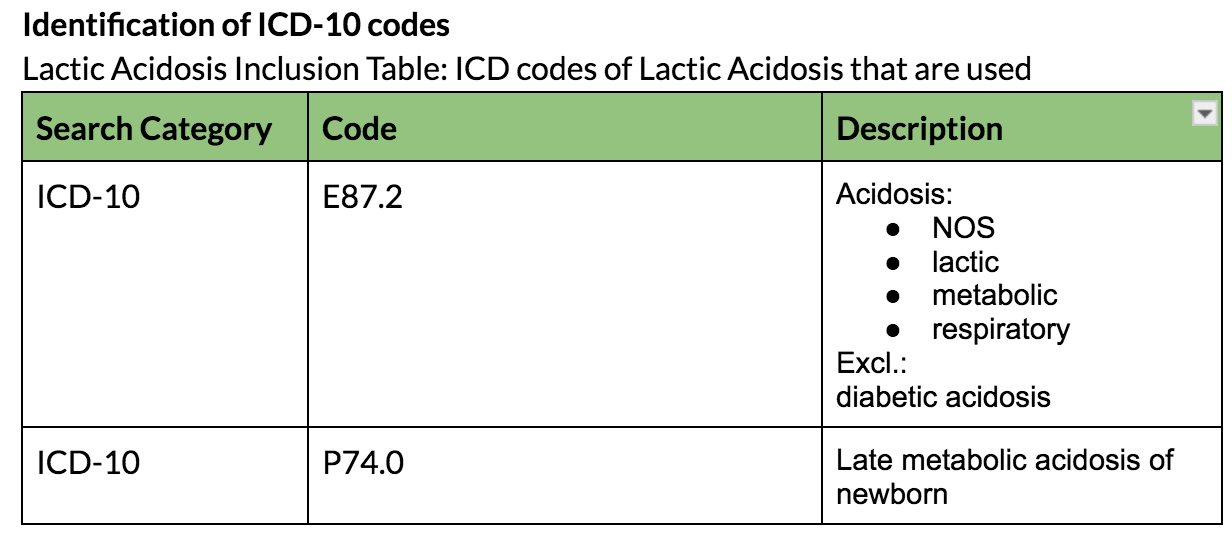

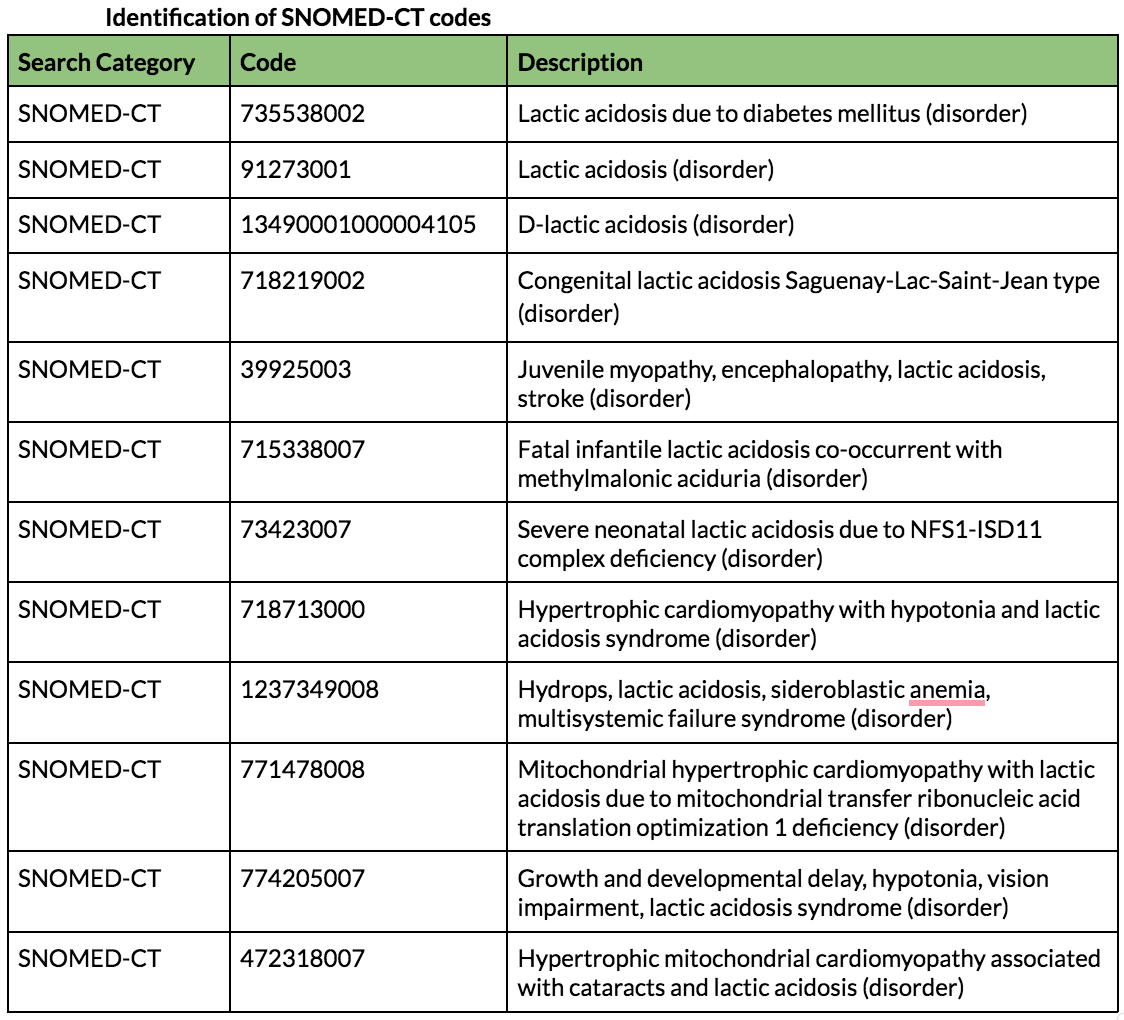

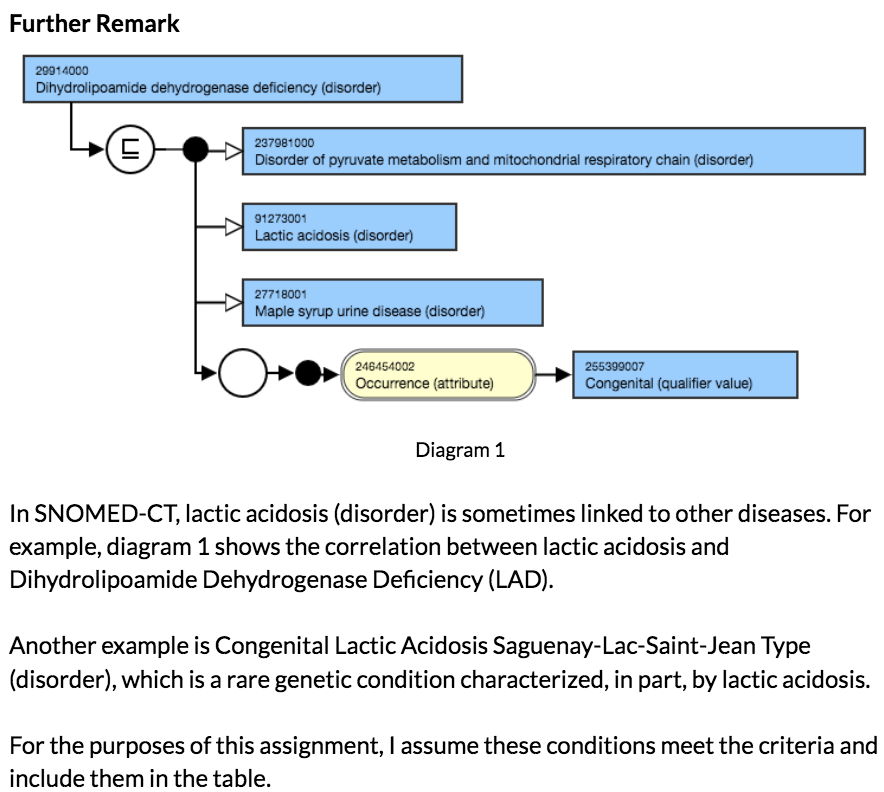

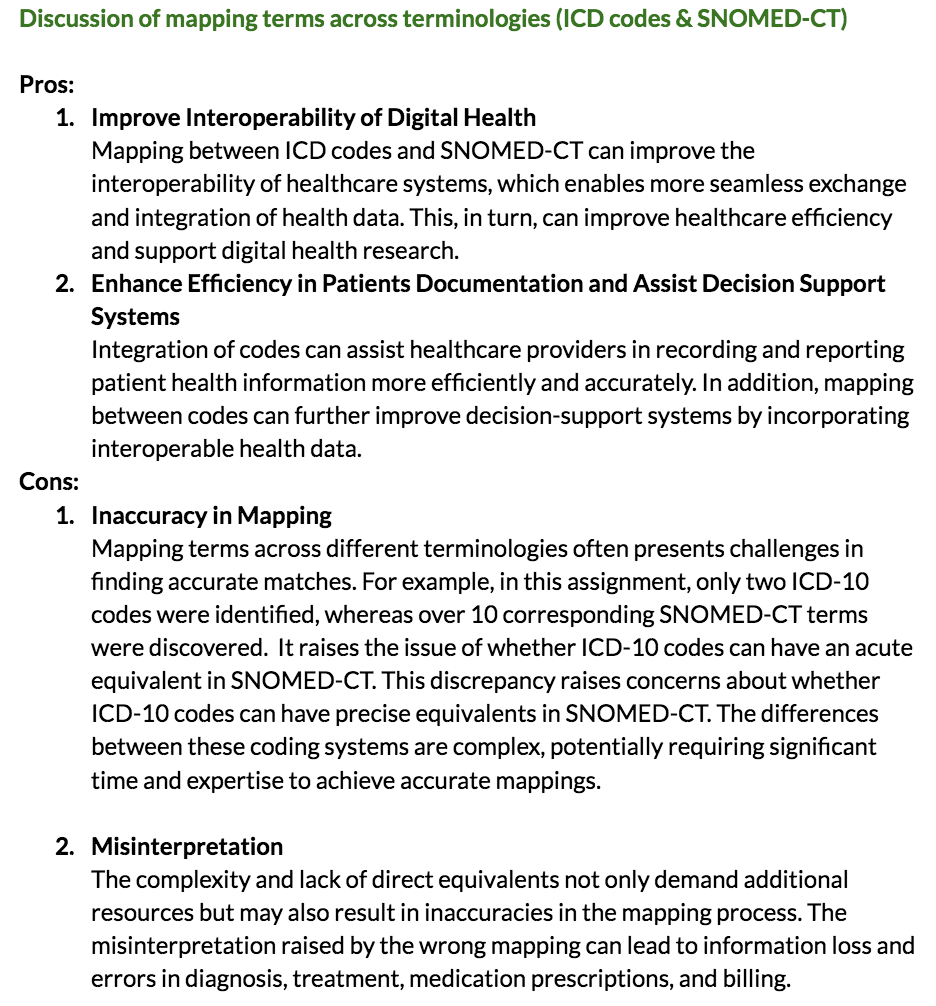

# **Implement Algorithm (with Written Description)**

## Load libraries and setup environment

In [ ]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [ ]:
# authenticate
auth.authenticate_user()

In [ ]:
# Set up environment variables
project_id = 'avian-line-432507-e6'

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
dataset = 'mimiciv'


Find the **"pH"** and **"Lactate"** in the Label columns inside the dictionary of Laboratory tests and get the corresponding itemid code.

* For the module hosp, 10 items of itemid were found: 52041, 50820, 52045, 50831, 51094, 52730, 51491, 50813, 52442, 53154

* For the module icu, 2 items of itemid were found: 220615, 226559

In [ ]:
##Module hosp:
df = run_query("""
SELECT *
FROM `physionet-data.mimiciv_hosp.d_labitems`
WHERE label LIKE "%pH%" OR label LIKE "Lactate"
""")
df.head(20)

,itemid,label,fluid,category
0,52041,pH,Fluid,Blood Gas
1,50813,Lactate,Blood,Blood Gas
2,50820,pH,Blood,Blood Gas
3,52442,Lactate,Blood,Blood Gas
4,52045,"pH, Urine",Urine,Blood Gas
5,50831,pH,Other Body Fluid,Blood Gas
6,53154,Lactate,Blood,Chemistry
7,51094,pH,Urine,Chemistry
8,52730,pH,Urine,Chemistry
9,51491,pH,Urine,Hematology


In [ ]:
##Module icu:
df2 = run_query("""
SELECT *
FROM `physionet-data.mimiciv_icu.d_items`
WHERE label LIKE "%pH%" OR label LIKE "%Lactate%"
""")
df2.head(20)

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,227586,GI pH,GI pH,chartevents,GI/GU,None,Numeric,NaN,NaN
1,220955,Ringers Lactate,Ringers Lactate,inputevents,Fluids - Other (Not In Use),mL,Solution,NaN,NaN
2,220967,Dextrose 5% / Ringers Lactate,Dextrose 5% / Ringers Lactate,inputevents,Fluids - Other (Not In Use),mL,Solution,NaN,NaN
3,220968,Dextrose 10% / Ringers Lactate,Dextrose 10% / Ringers Lactate,inputevents,Fluids - Other (Not In Use),mL,Solution,NaN,NaN
4,220980,Hextend (Hetastarch 6% in Lactate),Hextend (Hetastarch 6% in Lactate),inputevents,Fluids - Other (Not In Use),mL,Solution,NaN,NaN
5,220948,Lactate (ingr),Lactate (ingr),ingredientevents,Ingredients - general (Not In Use),mg,Ingredient,NaN,NaN


# **Patients Information**

From Module Hospital, retrieve the patients that have
1. Validated Lactate test;
2. and also intake of intravenous vasoactive drugs (Common intravenous vasoactive drugs: [Resource 3](https://my.clevelandclinic.org/health/treatments/23208-vasopressors))

In [ ]:
query = f"""
WITH LactateTests AS (
    SELECT le.*,dlab.label, dlab.fluid,
    FROM `physionet-data.mimiciv_hosp.labevents` AS le
    INNER JOIN `physionet-data.mimiciv_hosp.d_labitems` AS dlab
      ON le.itemid = dlab.itemid
    WHERE le.itemid IN (50813, 52442, 53154) AND le.valuenum > 4
),
Prescriptions AS (
    SELECT pa.subject_id, pre.drug
    FROM `physionet-data.mimiciv_hosp.patients` AS pa
    INNER JOIN `physionet-data.mimiciv_hosp.prescriptions` AS pre
      ON pa.subject_id = pre.subject_id
    WHERE pre.drug IN ('Norepinephrine', 'Vasopressin', 'Phenylephrine', 'Epinephrine', 'Dopamine', 'Angiotensin-II', 'Terlipressin')
)

SELECT lt.*, pr.drug
FROM LactateTests AS lt
INNER JOIN Prescriptions AS pr
  ON lt.subject_id = pr.subject_id
ORDER BY lt.subject_id
LIMIT 1000
"""
pt = run_query(query)
pt.head(10)

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments,label,fluid,drug
0,49735,10003400,20214994,54652956,50813,None,2137-02-26 13:20:00,2137-02-26 13:23:00,___,9.2,mmol/L,0.5,2.0,abnormal,None,VERIFIED.,Lactate,Blood,Vasopressin
1,49759,10003400,20214994,93075778,50813,None,2137-02-26 17:27:00,2137-02-26 17:32:00,___,7.8,mmol/L,0.5,2.0,abnormal,None,VERIFIED.,Lactate,Blood,Vasopressin
2,49537,10003400,20214994,11692539,50813,None,2137-02-26 00:27:00,2137-02-26 00:29:00,___,8.3,mmol/L,0.5,2.0,abnormal,None,VERIFIED.,Lactate,Blood,Vasopressin
3,49808,10003400,20214994,92343822,50813,None,2137-02-27 03:33:00,2137-02-27 03:39:00,___,4.2,mmol/L,0.5,2.0,abnormal,None,VERIFIED.,Lactate,Blood,Vasopressin
4,49598,10003400,20214994,7126457,50813,None,2137-02-26 04:40:00,2137-02-26 04:46:00,___,8.8,mmol/L,0.5,2.0,abnormal,None,___,Lactate,Blood,Vasopressin
5,49598,10003400,20214994,7126457,50813,None,2137-02-26 04:40:00,2137-02-26 04:46:00,___,8.8,mmol/L,0.5,2.0,abnormal,None,___,Lactate,Blood,Vasopressin
6,49878,10003400,20214994,44285906,50813,None,2137-02-28 10:59:00,2137-02-28 13:17:00,___,6.2,mmol/L,0.5,2.0,abnormal,None,VERIFIED.,Lactate,Blood,Vasopressin
7,49759,10003400,20214994,93075778,50813,None,2137-02-26 17:27:00,2137-02-26 17:32:00,___,7.8,mmol/L,0.5,2.0,abnormal,None,VERIFIED.,Lactate,Blood,Vasopressin
8,49591,10003400,20214994,25489779,50813,None,2137-02-26 04:38:00,2137-02-26 04:40:00,___,11.0,mmol/L,0.5,2.0,abnormal,None,VERIFIED.,Lactate,Blood,Vasopressin
9,49598,10003400,20214994,7126457,50813,None,2137-02-26 04:40:00,2137-02-26 04:46:00,___,8.8,mmol/L,0.5,2.0,abnormal,None,___,Lactate,Blood,Vasopressin


In [ ]:
##Module hosp with patients with pH test (Set LIMIT 1000):
query = f"""
SELECT le.*,dlab.label, dlab.fluid, dlab.label
FROM `physionet-data.mimiciv_hosp.labevents` AS le
INNER JOIN `physionet-data.mimiciv_hosp.d_labitems` AS dlab
  ON le.itemid = dlab.itemid
WHERE le.itemid in (52041, 50820, 50831)
ORDER BY subject_id LIMIT 1000
"""
pt2 = run_query(query)
pt2.head(10)

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments,label,fluid,label_1
0,1049,10000117,<NA>,71385598,50820,P51F7B,2174-10-14 14:52:00,2174-10-14 14:55:00,7.35,7.35,units,7.35,7.45,None,None,None,pH,Blood,pH
1,1063,10000117,<NA>,10100049,50820,P51F7B,2175-01-27 16:28:00,2175-01-27 16:31:00,7.36,7.36,units,7.35,7.45,None,None,None,pH,Blood,pH
2,5475,10000935,25849114,42157155,50820,None,2187-10-22 15:40:00,2187-10-22 15:42:00,7.41,7.41,units,7.35,7.45,None,None,None,pH,Blood,pH
3,8324,10000980,20897796,22563496,50820,None,2193-08-14 21:41:00,2193-08-14 21:43:00,7.33,7.33,units,7.35,7.45,abnormal,None,None,pH,Blood,pH
4,16615,10001884,26184834,38034879,50820,None,2131-01-11 01:51:00,2131-01-11 01:54:00,7.37,7.37,units,7.35,7.45,None,None,None,pH,Blood,pH
5,16622,10001884,26184834,66192556,50820,None,2131-01-11 02:49:00,2131-01-11 02:56:00,___,7.24,units,7.35,7.45,abnormal,None,VERIFIED. NO CALLS MADE - SAME ABNORMALITY PR...,pH,Blood,pH
6,16711,10001884,26184834,84172079,50820,None,2131-01-11 11:33:00,2131-01-11 11:35:00,7.33,7.33,units,7.35,7.45,abnormal,None,None,pH,Blood,pH
7,16717,10001884,26184834,30052577,50820,None,2131-01-11 14:48:00,2131-01-11 14:51:00,7.36,7.36,units,7.35,7.45,None,None,None,pH,Blood,pH
8,16765,10001884,26184834,8788212,50820,None,2131-01-12 03:48:00,2131-01-12 03:53:00,7.36,7.36,units,7.35,7.45,None,None,None,pH,Blood,pH
9,15837,10001884,<NA>,17165845,50820,None,2130-10-19 13:58:00,2130-10-19 14:00:00,7.44,7.44,units,7.35,7.45,None,None,None,pH,Blood,pH


**Find the patients with Lactic acidosis that lasted > 120 minutes and was corrected after the use of intravenous vasoactive drugs.**

Therefore, the logic of the code is to
1. Find patients with Lactic acidosis
2. Lactic Acidosis was corrected (lactate valuenum < 4) after the use of intravenous vasoactive drugs

**Why pH value is not viewed as the selection criteria?**

A pH value lower than 7.35 is considered to be associated with the disease, but it is not the cause of the disease. Additionally, in cases of lactic acidosis, due to other physiological reactions, the pH value may not necessarily drop below 7.35. Therefore, at this stage, it was decided not to use the pH value as a criterion.

Please refer to: [Definition Source 1](https://www.uptodate.com/contents/causes-of-lactic-acidosis?topicRef=2291&source=related_link)


In [ ]:
## Create a dataframe copy to work with. Keep entries with 2 or more info (to compare date difference).
import warnings
warnings.filterwarnings('ignore')

#Use lactate valuenum to filter the patients
#hosp_pH = pt1.copy()
hosp_lactate = pt.copy()

## Transform the value column Dtype in float: (it's current an object)
hosp_lactate['valuenum'] = pd.to_numeric(hosp_lactate['valuenum'], errors='coerce')

## Find only patients with 2 or more data, so you can compare a time difference between them.
keep_duplicated = hosp_lactate.duplicated(subset='subject_id',keep=False)
hosp_lactate['duplicated'] = keep_duplicated
hosp_lactate = hosp_lactate[hosp_lactate['duplicated']==True]
del hosp_lactate['duplicated']


#ic_sorted = hosp_lactateH.sort_values(by='charttime')
#Sort the dataframe by ascending order time using the column 'charttime'.
#ic_sorted.reset_index(inplace=True, drop=True)

#Sort the dataframe by ascending order time using the column 'charttime'.
ic_sorted = hosp_lactate.sort_values(by='charttime')
ic_sorted.reset_index(inplace=True, drop=True)

# Get the unique list of patient's id within the final set to iterate over them in the next section code.
patients = list(ic_sorted['subject_id'].unique())
print(patients)

[10006053, 10196073, 10076958, 10017851, 10104674, 10098215, 10192651, 10184600, 10173670, 10143305, 10087623, 10084586, 10110764, 10055939, 10199726, 10026161, 10018081, 10194609, 10011427, 10146735, 10003400, 10104450, 10094679, 10039708, 10206125, 10179495, 10150335, 10057482, 10007818, 10083576, 10095570, 10111112, 10097659, 10126201, 10155871, 10165963, 10054208, 10104308, 10098993, 10132611, 10070614, 10112880, 10055344, 10102878, 10199560, 10023117, 10157331, 10049642, 10118141, 10150812, 10082560, 10051074, 10186500, 10109639, 10202236, 10151556, 10037975, 10137856, 10115044, 10069423, 10004235, 10036086, 10152414]


In [ ]:
import pandas as pd

# Assuming ic_sorted is the initial DataFrame and patients is a list of patient IDs

patients = patients[0:30]  # Focus on the first 30 patients

# Initialize an empty DataFrame to store results
found_subset = pd.DataFrame()

# Loop through each patient ID
for each in patients:
    # Filter data for the current patient and reset the index
    subset = ic_sorted.loc[ic_sorted['subject_id'] == each].reset_index(drop=True)

    # Calculate the time difference between consecutive entries in hours
    subset['Diff_Time_Hours'] = subset["charttime"].diff().dt.total_seconds() / 3600

    # Iterate through the values to find any valuenum greater than 4
    # It means that the patients previously had Lactic Acidosis Disease
    high_value_found = False
    for index, value in enumerate(subset['valuenum']):
        if value > 4:
            high_value_found = True
        # Once a high value is found, check for any subsequent low value (<4)
        # It indicates that the patients' symptoms were corrected after the drug
        if high_value_found and value < 4:
            # If the condition is met, add this subset from the high value point onward to the found_subset DataFrame
            found_subset = pd.concat([found_subset, subset.iloc[index:]], ignore_index=True)
            break  # Assuming only the first occurrence after a high value is needed for the task

    #Can choose to print each subset for debugging (Optional)
    #print(subset)

# After the loop, found_subset will contain all the entries that meet the task criteria
if not subset.loc[(subset['Diff_Time_Hours'] > 2)].empty:

   found_subset = pd.concat([found_subset, subset], ignore_index=True)
print("Found subsets meeting the criteria:")
print(found_subset)

Found subsets meeting the criteria:
   labevent_id  subject_id  hadm_id  specimen_id  itemid order_provider_id  \
0      1647541    10146735     <NA>     95588223   50813              None   
1      1647541    10146735     <NA>     95588223   50813              None   
2      1647541    10146735     <NA>     95588223   50813              None   
3      1648810    10146735     <NA>     47426569   50813              None   
4      1648810    10146735     <NA>     47426569   50813              None   
5      1648810    10146735     <NA>     47426569   50813              None   

            charttime           storetime value  valuenum valueuom  \
0 2136-12-23 07:10:00 2136-12-23 07:16:00   ___       4.1   mmol/L   
1 2136-12-23 07:10:00 2136-12-23 07:16:00   ___       4.1   mmol/L   
2 2136-12-23 07:10:00 2136-12-23 07:16:00   ___       4.1   mmol/L   
3 2139-02-19 15:14:00 2139-02-19 15:24:00   ___      13.4   mmol/L   
4 2139-02-19 15:14:00 2139-02-19 15:24:00   ___      13.4   mmol/L 